## 3. Классификация

При обработке изображения, нужно определить, является ли она *ведущей (первой)* страницей в документе или нет. Это необходимо, если нам на вход подают несколько документов постранично, и мы хотим разделить их на отдельные документы.

Соответственно, нужно определить, является ли изображение *ведущей* **(первой)** страницей документа. В данном задании можно использовать как методы CV, так и NLP на извлеченном тексте.

In [1]:
import os
import random
import cv2
from tqdm import tqdm
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
import xml.etree.ElementTree as ET
from PIL import Image
from pathlib import Path
import tensorflow as tf
import random
import re
import pickle

random.seed(1)

2021-10-03 20:22:09.472390: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0


In [ ]:
gpu_device = tf.config.experimental.list_physical_devices('GPU')
if gpu_device:
    tf.config.experimental.set_memory_growth(gpu_device[0], True)

In [3]:
DATA_ROOT = '../pages/'

IM_SIZE = (224,224) # Все изображения будут приведены этому размеру

class_names = {'other':0, 'main': 1}       

In [4]:
images_path = Path(DATA_ROOT+'source/')
annotation_path = Path(DATA_ROOT+'truth/')

In [5]:
def filelist(root, file_type):
    """Функция возвращает полностью квалифицированный список файлов в директории"""
    return [os.path.join(directory_path, f) for directory_path, directory_name, 
            files in os.walk(root) for f in files if f.endswith(file_type)]

In [6]:
data_list = []
files = filelist(images_path, '.tif')
for f in files:
    data = {}
    data['doc_name'] = f
    if re.search(r'\_1.tif', f) == None and re.search(r'\_\d{1,2}.tif', f):
        
        data['type'] ='other'
    else:
        data['type'] = 'main'
    data_list.append(data)
df = pd.DataFrame(data_list)

In [7]:
df.head(3)

,doc_name,type
0,../pages/source/irn90c00-page02_2.tif,other
1,../pages/source/nuu04e00.tif,main
2,../pages/source/juo75f00_26.tif,other


In [8]:
df['type'].value_counts()

main     572
other    428
Name: type, dtype: int64

In [9]:
df['type'] = df['type'].apply(lambda x: class_names[x])

In [10]:
df['type'].value_counts()

1    572
0    428
Name: type, dtype: int64

### Перемешаем выборку

In [11]:
df = df.sample(frac=1).reset_index(drop=True)

### Разделим датасет на тренировочную, тестовую и валлидационную выборки.

In [12]:
test_count = math.floor(len(df)*0.4)

train_df_classify = df.iloc[:-test_count]

test_df_classify =  df.iloc[-test_count:]

val_df_classify =  test_df_classify.iloc[:test_count//2]

test_df_classify =  test_df_classify.iloc[test_count//2:]

In [13]:
len(train_df_classify), +len(test_df_classify), len(test_df_classify)

(600, 200, 200)

In [14]:
train_df_classify['type'].value_counts()

1    337
0    263
Name: type, dtype: int64

In [15]:
test_df_classify['type'].value_counts()

1    117
0     83
Name: type, dtype: int64

In [16]:
val_df_classify['type'].value_counts()

1    118
0     82
Name: type, dtype: int64

### Генератор. 

In [17]:
def keras_generator(gen_df, batch_size = 1, is_test=False):

    ind = np.arange(0,len(gen_df))
    random.shuffle(ind)

    while True:
        X_batch = []
        y_batch = []

        for i in range(batch_size):
          img_name, class_ind = gen_df.sample(1).values[0]
          
          img = Image.open(str(img_name))

          with tf.device('CPU'):
            img = tf.keras.preprocessing.image.img_to_array(img.convert('RGB'))
            img = tf.keras.preprocessing.image.smart_resize(img, IM_SIZE, interpolation='bilinear')

          y_batch.append(class_ind)
          X_batch.append(img)

        X_batch = np.array(X_batch, dtype='float') /255.0
        y_batch = np.array(y_batch, dtype='uint8')
   
        yield X_batch, y_batch

In [18]:
def show_images(images,labels_ind, true_ind=None):
    num_of_images = len(images)

    fig, axes = plt.subplots(1, num_of_images, 
            figsize=(3 * num_of_images, 3 * num_of_images) # Размер изображений будет зависет от из к-ва в строке. 
            )

    for i, (image_pixels,label_ind) in enumerate(zip(images,labels_ind)):
      
        # title_text = class_names[np.argmax(label_ind)]
        # print(label_ind)
        title_text = str(label_ind)
        
        if true_ind is not None:
            title_text += f' true = {true_ind[i]}'

        axes[i].imshow(image_pixels)
        axes[i].title.set_text(title_text)

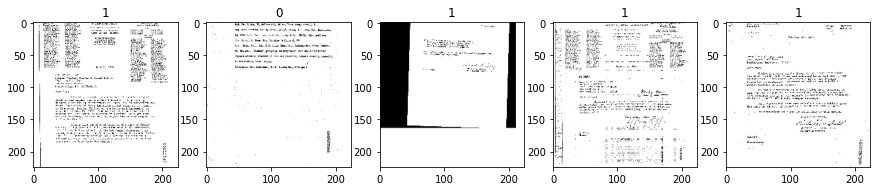

In [20]:
for X_test, y_test in keras_generator(df, batch_size=5):
  break

show_images(X_test, y_test)

In [21]:
from tensorflow.keras.applications.resnet50 import ResNet50
from keras.models import Model
# from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout

In [22]:
base_model = ResNet50(input_shape=(IM_SIZE[0], IM_SIZE[1], 3), include_top=False, pooling='avg')

output = base_model.output

x = Dropout(0.3)(output)
out = tf.keras.layers.Dense(1, activation='sigmoid', name='score')(x) # Этим выводам нужно присвоить названия.

model_classify = tf.keras.models.Model(inputs=base_model.input, outputs=out)   

In [33]:
# model_classify.summary()

In [23]:
optimizer = tf.keras.optimizers.Adam(learning_rate = 0.0001)

# # компиляция модели
model_classify.compile(loss='binary_crossentropy',
              optimizer=optimizer,
              metrics=['accuracy'])

In [35]:
checkpoint_best_accuracy = tf.keras.callbacks.ModelCheckpoint('models/model_classify_best_accuracy.h5',
                                                  monitor='val_accuracy',
                                                  mode='max',
                                                  save_best_only=True,
                                                  save_weights_only=True,
                                                  save_freq='epoch',
                                                  verbose=1
                                                 )
checkpoint_best_Loss = tf.keras.callbacks.ModelCheckpoint('models/model_classify_best_loss.h5',
                                                  monitor='val_loss',
                                                  mode='auto',
                                                  save_best_only=True,
                                                  save_weights_only=True,
                                                  save_freq='epoch',
                                                  verbose=1
                                                 )

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_accuracy',
                                                 factor=0.1,
                                                 patience=10, 
                                                 min_lr=0.00001,
                                                 verbose=0, 
                                                 mode="max")


In [26]:
batch_size_training = 16
batch_size_testing = 8

In [27]:
steps_per_epoch_training = len(train_df_classify)//batch_size_training
steps_testing = len(test_df_classify)//batch_size_testing
steps_val = len(val_df_classify)//batch_size_testing
num_epochs = 100

steps_per_epoch_training, steps_val, steps_testing

(37, 25, 25)

In [28]:
train_generator = keras_generator(train_df_classify,batch_size=batch_size_training)
test_generator = keras_generator(test_df_classify,batch_size=batch_size_testing)
val_generator = keras_generator(val_df_classify,batch_size=batch_size_testing)

In [44]:
NUM_EPOCHS = 100

history = model_classify.fit(train_generator,
                       epochs=NUM_EPOCHS,
                       steps_per_epoch = steps_per_epoch_training,
                       validation_data= val_generator,
                       validation_steps= steps_val, 
                       shuffle=True,
                       callbacks = [checkpoint_best_accuracy, checkpoint_best_Loss, reduce_lr],
                       verbose=1,
                       )

Epoch 1/100
37/37 [==============================] - 94s 3s/step - loss: 0.2447 - accuracy: 0.9003 - val_loss: 1.1630 - val_accuracy: 0.6350

Epoch 00001: val_accuracy improved from -inf to 0.63500, saving model to models/model_classify_best_accuracy.h5

Epoch 00001: val_loss improved from inf to 1.16302, saving model to models/model_classify_best_loss.h5
Epoch 2/100
37/37 [==============================] - 76s 2s/step - loss: 0.1381 - accuracy: 0.9628 - val_loss: 0.8325 - val_accuracy: 0.4400

Epoch 00002: val_accuracy did not improve from 0.63500

Epoch 00002: val_loss improved from 1.16302 to 0.83252, saving model to models/model_classify_best_loss.h5
Epoch 3/100
37/37 [==============================] - 88s 2s/step - loss: 0.0840 - accuracy: 0.9730 - val_loss: 1.0337 - val_accuracy: 0.3150

Epoch 00003: val_accuracy did not improve from 0.63500

Epoch 00003: val_loss did not improve from 0.83252
Epoch 4/100
37/37 [==============================] - 93s 3s/step - loss: 0.0436 - accura

In [30]:
eval = model_classify.evaluate(test_generator,steps=steps_testing, verbose=0)
print('Model performance:')
print('loss for test dataset is : {}'.format(eval[0]))
print('accuracy for test dataset is : {}'.format(eval[1]))

Model performance:
loss for test dataset is : 0.2501855492591858
accuracy for test dataset is : 0.9599999785423279


In [47]:
model_classify.save(f'models/model_cassify_{NUM_EPOCHS}.hdf5')

/home/sergey/anaconda3/envs/imageai_env/lib/python3.8/site-packages/tensorflow/python/keras/utils/generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


In [24]:
model_classify.load_weights('models/model_classify_best_accuracy.h5')

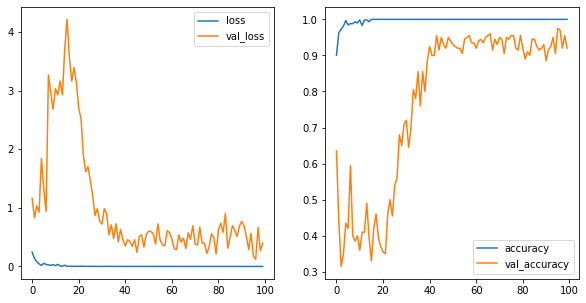

In [48]:
fig, ax = plt.subplots(1,2, figsize=(10,5))
ax[0].plot(history.history['loss'],label='loss')
ax[0].plot(history.history['val_loss'],label='val_loss')
ax[0].legend()
ax[1].plot(history.history['accuracy'],label='accuracy')
ax[1].plot(history.history['val_accuracy'],label='val_accuracy')
ax[1].legend()
plt.show()

Проверим результаты. 

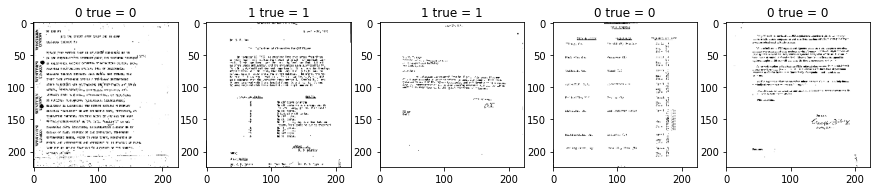

In [50]:
for X_test, y_test in keras_generator(test_df_classify,batch_size=5):
  break

pred = model_classify.predict(X_test)

pred_y = [int(np.round(p[0])) for p in pred]

show_images(X_test, pred_y, y_test)

In [31]:
# Сохраним финальный вариант модели. с лучшим результатом.
model_classify.save(f'../models/model_classify.h5')

/home/sergey/anaconda3/envs/imageai_env/lib/python3.8/site-packages/tensorflow/python/keras/utils/generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


## Сохраним модель в формате-pickle.

In [32]:
# Сохранение модели. 
model_dict = {}

model_dict['graph'] = model_classify.to_json()
model_dict['weights'] = model_classify.get_weights()

In [33]:
with open('../models/page_classify_model.pickle', 'wb') as f:
    pickle.dump(model_dict, f, protocol=pickle.HIGHEST_PROTOCOL)

### Проверим качество предсказания после того как модель будет восстановлена.

In [34]:
with open('../models/page_classify_model.pickle', 'rb') as f:
   model_dict_restore = pickle.load(f)
   
model = tf.keras.models.model_from_json(model_dict_restore['graph'])
model.set_weights(model_dict_restore['weights'])

In [35]:
# # компиляция модели
model.compile(loss='binary_crossentropy',
              optimizer=optimizer,
              metrics=['accuracy'])

In [36]:
eval = model.evaluate(test_generator,steps=steps_testing, verbose=0)
print('Model performance:')
print('loss for test dataset is : {}'.format(eval[0]))
print('accuracy for test dataset is : {}'.format(eval[1]))

Model performance:
loss for test dataset is : 0.2684510350227356
accuracy for test dataset is : 0.9599999785423279


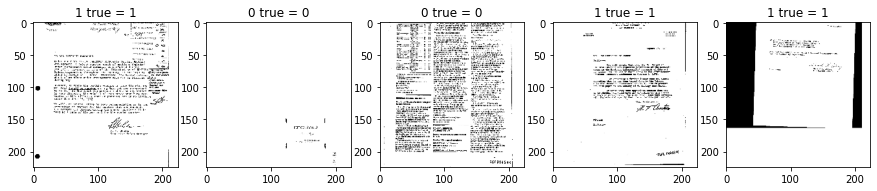

In [62]:
for X_test, y_test in keras_generator(test_df_classify, batch_size=5):
  break

pred = model.predict(X_test)

pred_y = [int(np.round(p[0])) for p in pred]

show_images(X_test, pred_y, y_test)